In [58]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_log_error, make_scorer

import sklearn
sklearn.set_config(transform_output="pandas")
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split

## Шаг 1: Загрузка датасетов

In [59]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## Шаг 2: Базовая визуализация

### 2.1: Распределение цен на дома

<Axes: title={'center': 'Распределение цен на дома'}, xlabel='Price', ylabel='Count'>

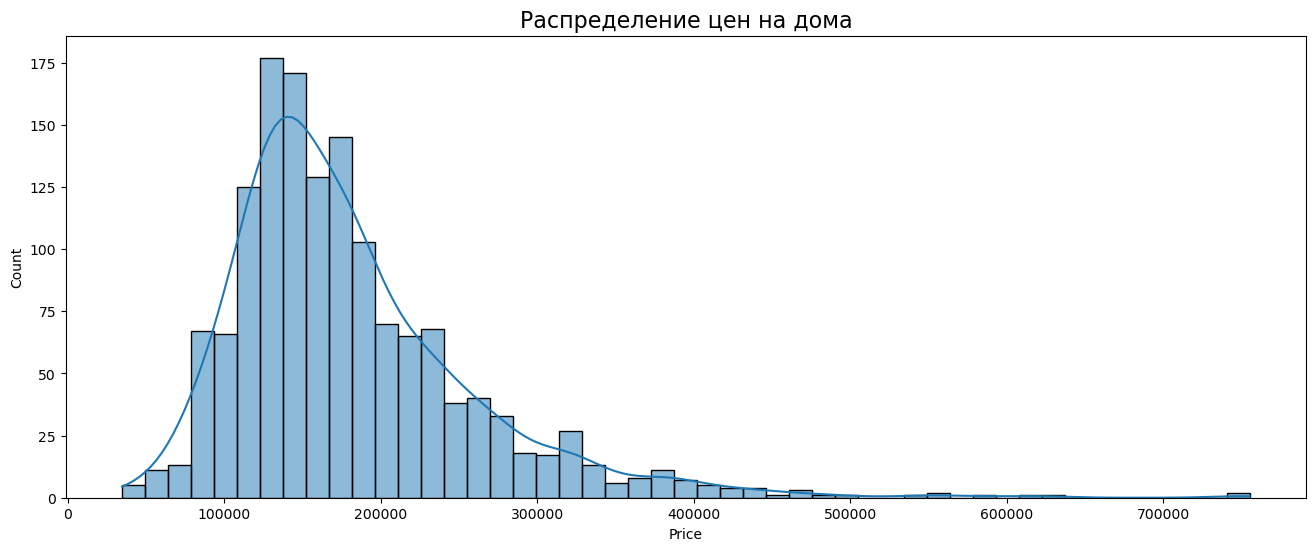

In [60]:
plt.figure(figsize=(16,6))
plt.title('Распределение цен на дома', fontsize=16)
plt.xlabel('Price')
sns.histplot(train['SalePrice'], kde=True)


### 2.2: Сабплот с гистограмами числовых признаков

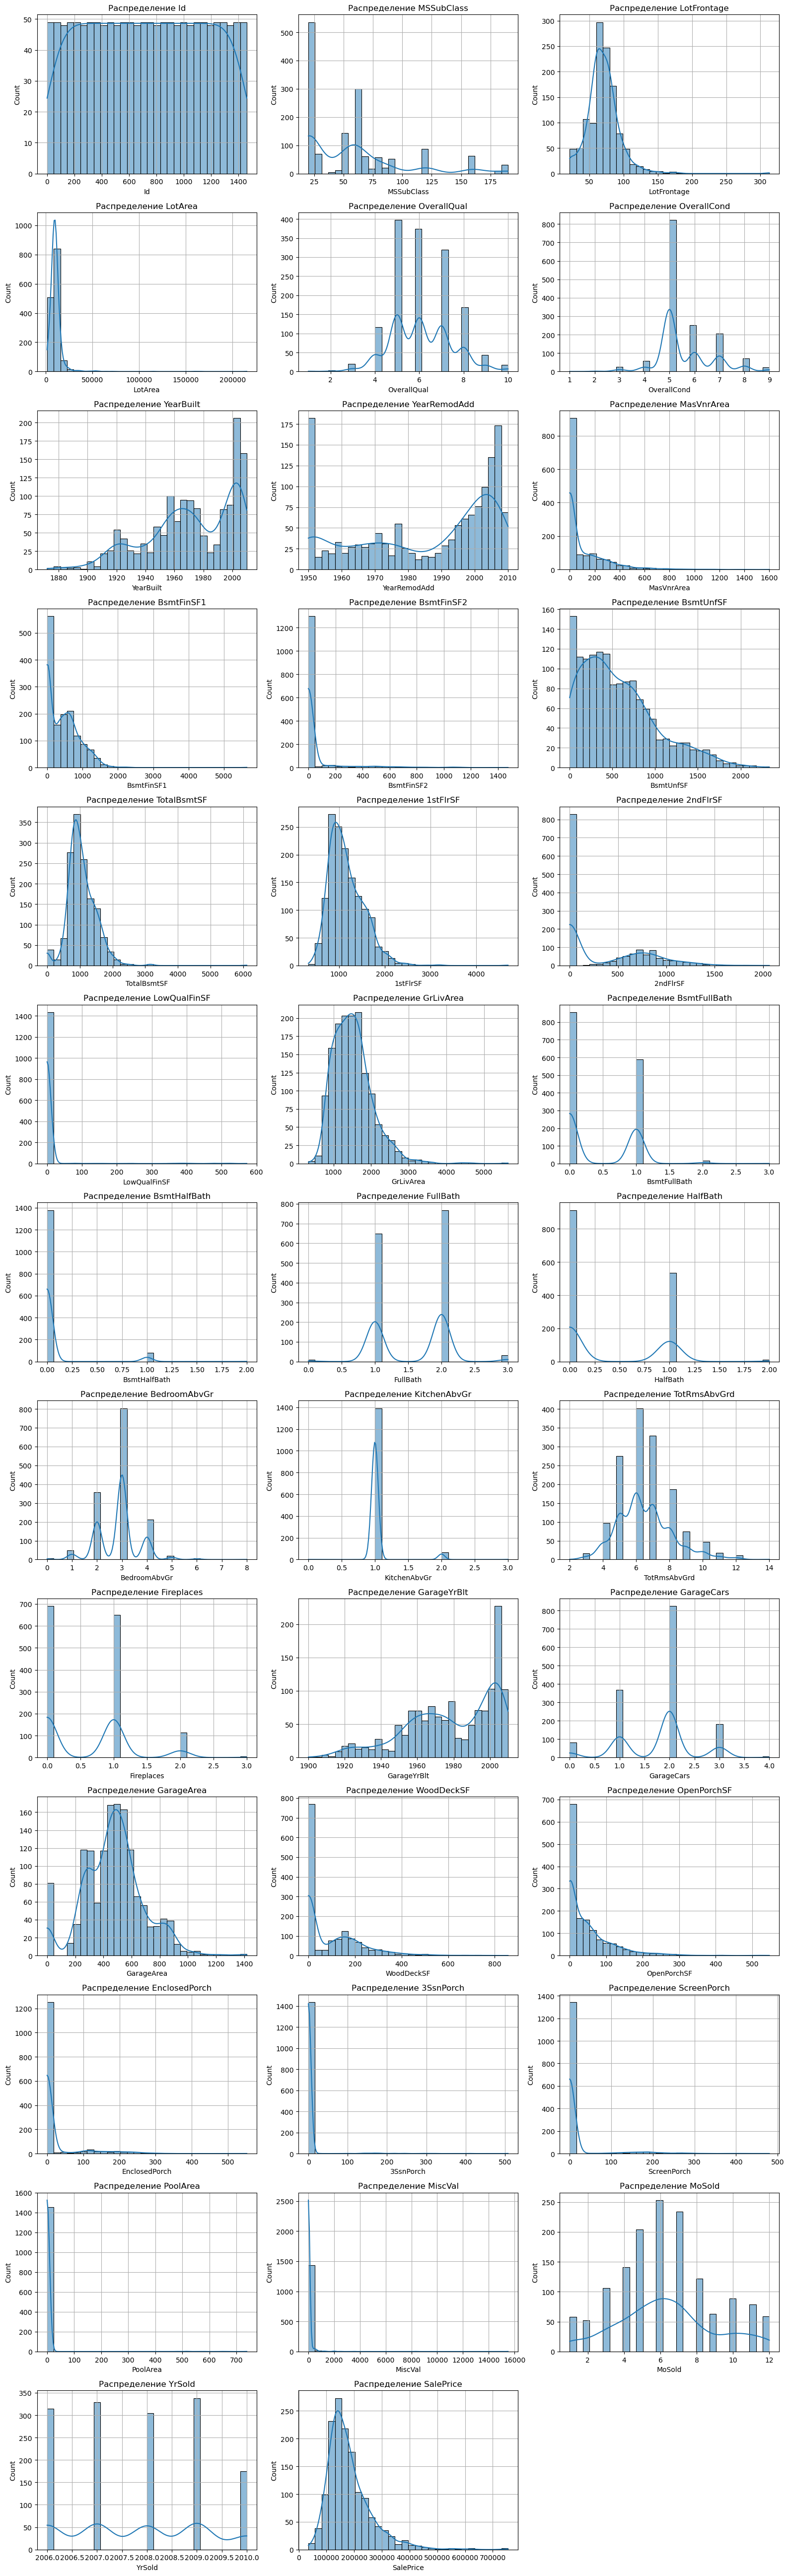

In [61]:
numeric_features = train.select_dtypes(include=['float64', 'int64']).columns
n_numeric = len(numeric_features)
cols = 3
rows = (n_numeric // cols) + int(n_numeric % cols != 0)

fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 4))
axes = axes.flatten()

for i, col in enumerate(numeric_features):
    sns.histplot(train[col], kde=True, ax=axes[i], bins=30)
    axes[i].set_title(f'Распределение {col}')
    axes[i].grid(True)

for i in range(n_numeric, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

### 2.3: Cабплот с барплотами категориальных признаков

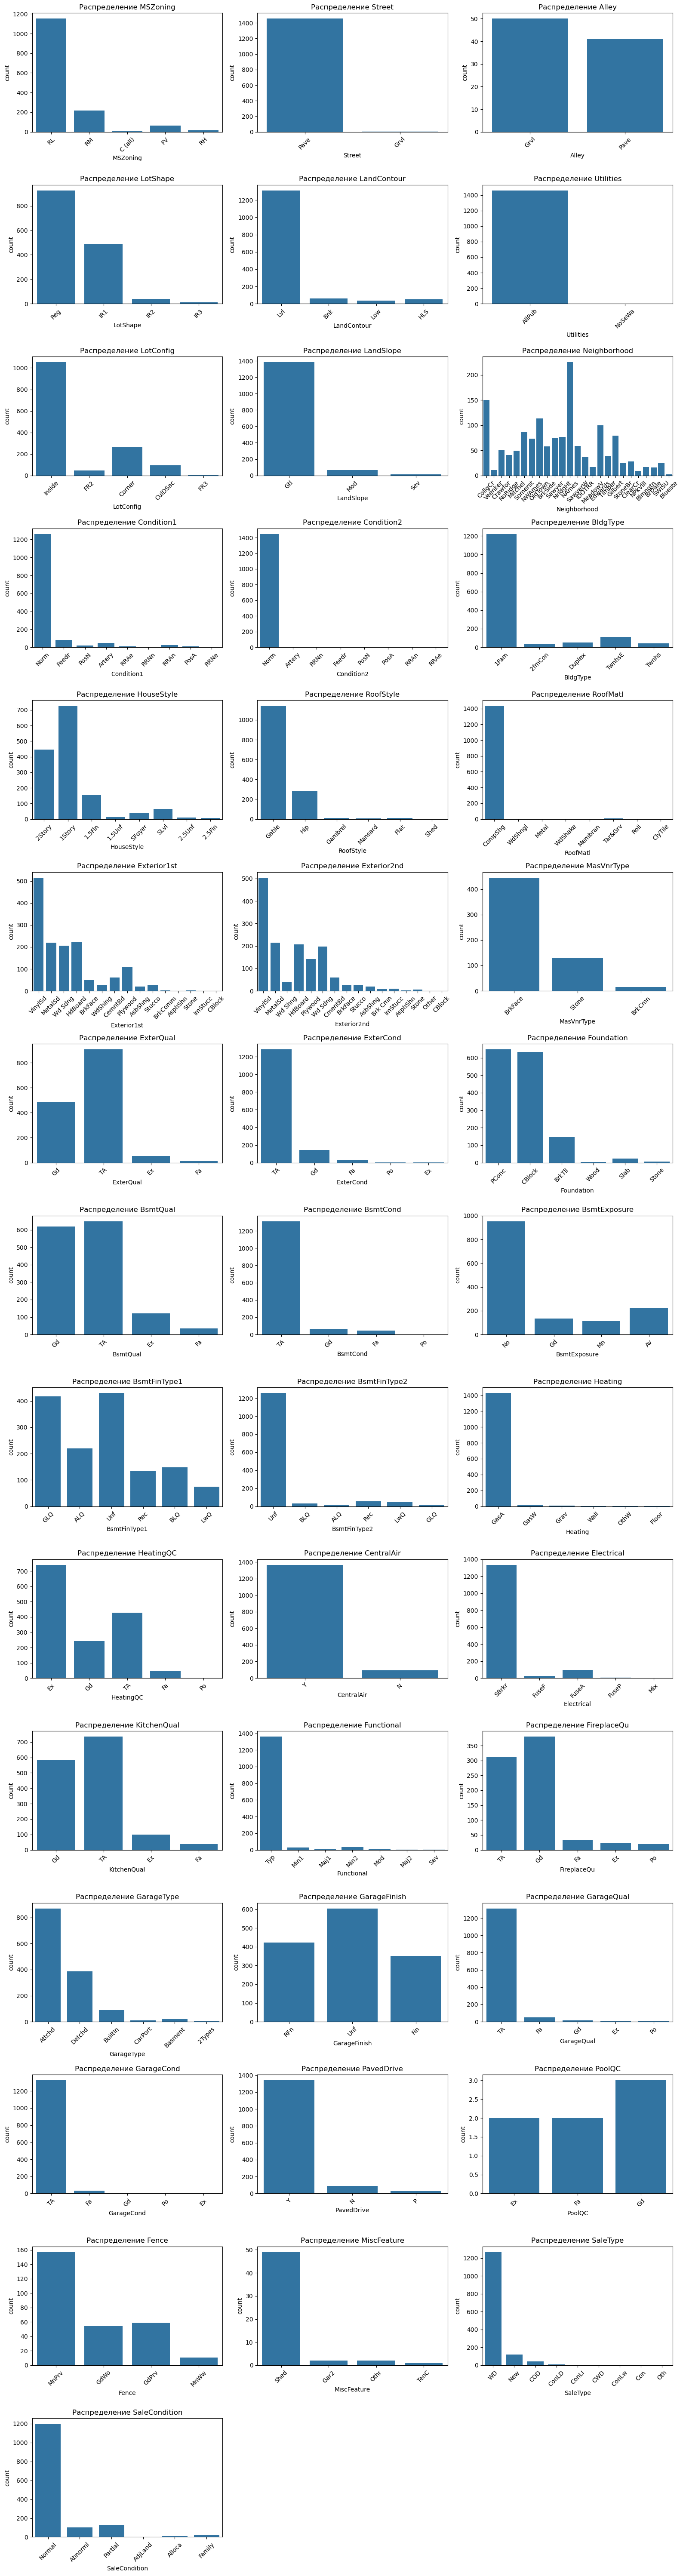

In [62]:
categorical_features = train.select_dtypes(include=['object', 'category']).columns
n_categorical = len(categorical_features)
cols = 3
rows = (n_categorical // cols) + int(n_categorical % cols != 0)

fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 4))
axes = axes.flatten()

for i, col in enumerate(categorical_features):
    sns.countplot(x=train[col], ax=axes[i])
    axes[i].set_title(f'Распределение {col}')
    axes[i].tick_params(axis='x', rotation=45)

for i in range(n_categorical, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


### 2.4: Матрица корреляций числовых признаков

<Axes: >

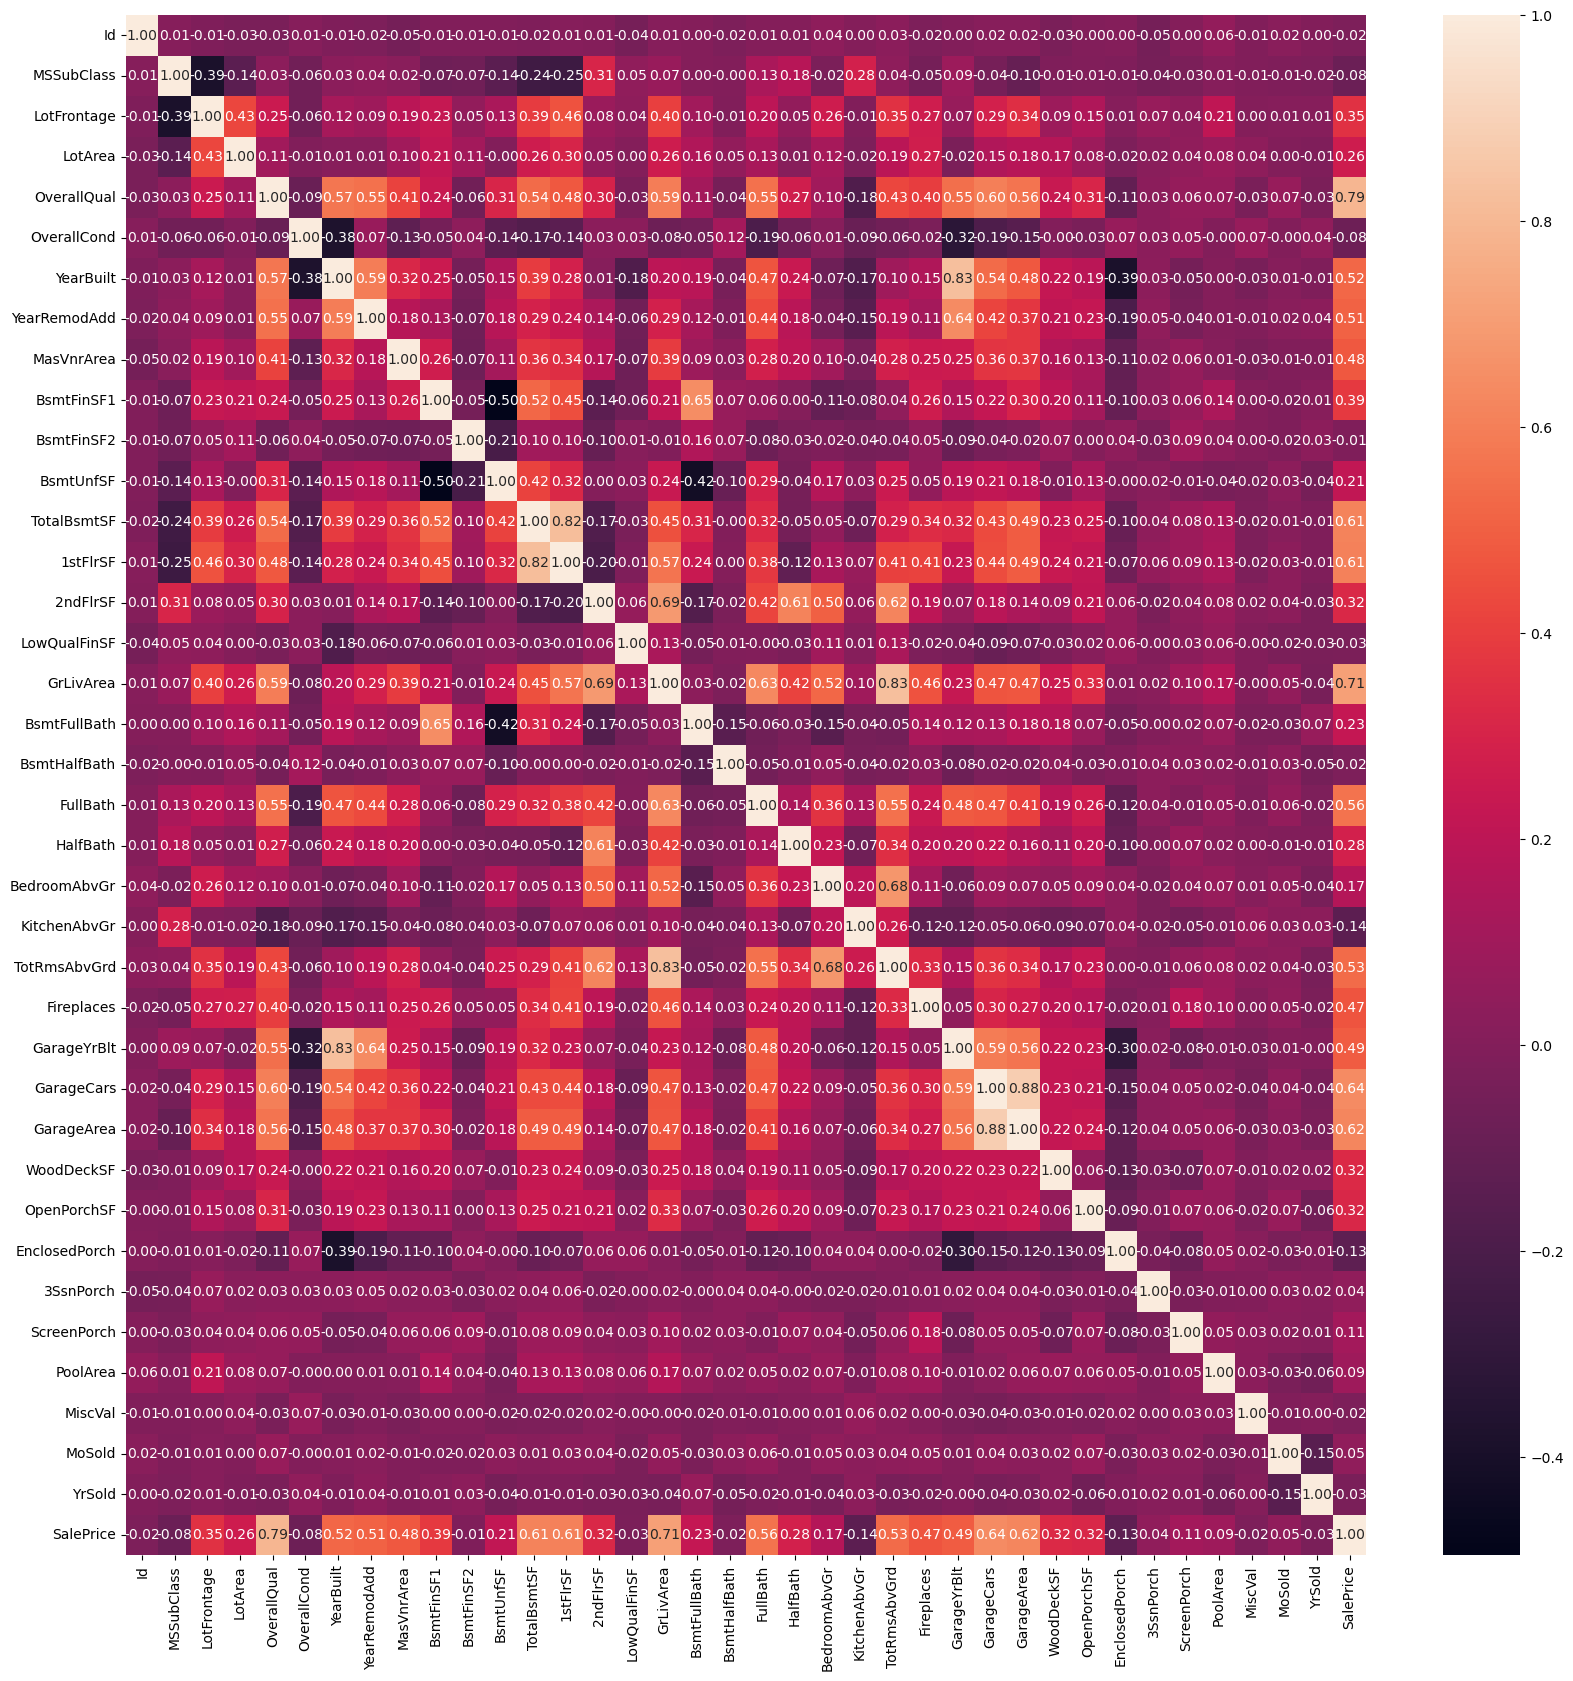

In [63]:
cor_matr = train[numeric_features]
plt.figure(figsize=(20,20))
sns.heatmap(cor_matr.corr(), annot=True, fmt='.2f')

## Шаг 3: Логорифмирования таргета и инициализацция x_train, y_train

In [64]:
x_train, y_train = train.drop('SalePrice',axis=1), np.log(train['SalePrice'])

## Шаг 4: Обьединение обучающей и тестовой выборки в единый датафрейм, начало сбора Pipeline

In [65]:
df_merged = pd.concat([train, test], axis=0, ignore_index=True)

### 4.1: Сбор Pipeline

In [66]:
columns_to_drop = ['Alley', 'PoolQC', 'Fence', 'MiscFeature', 'Id'] # колонки которые мы убираем так как в них количество  пропусков близится к количество ID, по сути пустые колонки

my_imputer = ColumnTransformer(
    transformers = [
        ('drop_features', 'drop', columns_to_drop),
        ('cat_imputer', SimpleImputer(strategy='most_frequent'), ['LotFrontage', 'Electrical', 'MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'KitchenQual', 'Functional', 'GarageCars', 'SaleType']),
        ('num_imputer_0', SimpleImputer(strategy='constant', fill_value='0'), ['MasVnrType', 'BsmtUnfSF' ,'BsmtQual', 'MasVnrArea', 'BsmtExposure', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']),
        ('num_imputer_mean', SimpleImputer(strategy='mean'), ['BsmtFinSF2','BsmtFinSF1', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageArea'])
    ],
    verbose_feature_names_out=False,
    remainder='passthrough'
)
# категориальный колонки 
cat_columns = [
    'MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual','GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition'
]  
# численныые колонки за вычетом SalePrice для нормализации
num_columns = [
       'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold'
       ] 
# колонки для ordinal_encoding только с двумя вариантами данных 
ordinal_encoding_columns = [
    'Street', 'Utilities', 'CentralAir'
] 
one_hot_encoding_columns = [col for col in cat_columns if col not in ordinal_encoding_columns] # колонки для one_hot_encoding


scaler_and_encoder = ColumnTransformer(
    transformers=[
        ('original encoding', OrdinalEncoder(), ordinal_encoding_columns),
        ('one_hot_encoding', OneHotEncoder(sparse_output=False), one_hot_encoding_columns),
        ('scaling', StandardScaler(), num_columns)
    ],
    verbose_feature_names_out=False, 
    remainder= 'passthrough' 
)

preprocessor = Pipeline(
    [
        ('imputer_and_dropper', my_imputer),
        ('scaler_and_encoder', scaler_and_encoder)
    ]
)

In [67]:
x = preprocessor.fit_transform(df_merged) # подготовленные данные для ML
x

,Street,Utilities,CentralAir,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR1,LotShape_IR2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.740760,0.200006,-0.359601,-0.103331,-0.285935,-0.06315,-0.089592,-1.552184,0.157646,208500.0
1,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.614879,-0.702843,-0.359601,-0.103331,-0.285935,-0.06315,-0.089592,-0.446925,-0.602962,181500.0
2,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,-0.740760,-0.081209,-0.359601,-0.103331,-0.285935,-0.06315,-0.089592,1.026753,0.157646,223500.0
3,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,-0.740760,-0.184815,3.874967,-0.103331,-0.285935,-0.06315,-0.089592,-1.552184,-1.363569,140000.0
4,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.776967,0.540424,-0.359601,-0.103331,-0.285935,-0.06315,-0.089592,2.132012,0.157646,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.740760,-0.702843,-0.359601,-0.103331,-0.285935,-0.06315,-0.089592,-0.078505,-1.363569,NaN
2915,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.740760,-0.347624,-0.359601,-0.103331,-0.285935,-0.06315,-0.089592,-0.815344,-1.363569,NaN
2916,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,3.006130,-0.702843,-0.359601,-0.103331,-0.285935,-0.06315,-0.089592,1.026753,-1.363569,NaN
2917,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.108374,-0.229217,-0.359601,-0.103331,-0.285935,-0.06315,1.144312,0.289914,-1.363569,NaN


## Шаг 5: Разьединение выборок обратно

In [68]:
train_ml_ready, test_ml_ready = x[x['SalePrice'].notna()], (x[x['SalePrice'].isna()]) # разделение датасетов на train и test по колонке SalePrice
test_ml_ready = test_ml_ready.drop('SalePrice', axis=1)

In [76]:
x_train, y_train = train_ml_ready.drop('SalePrice', axis=1), train_ml_ready['SalePrice'] # разделение на фитчи и таргет
x_train_split, x_val, y_train_split, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

## 6 Нахождение оптимальных параметров для XGBoost и LightGBM и обучение этих моделей

#### LightGBM

In [77]:
# import logging

# logging.getLogger("lightgbm").setLevel(logging.CRITICAL)
# logging.getLogger("optuna").setLevel(logging.CRITICAL)

# def objective_lgbm(trial):
#     params = {
#         "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=50),
#         "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
#         "max_depth": trial.suggest_int("max_depth", 3, 15),
#         "num_leaves": trial.suggest_int("num_leaves", 7, 127),
#     }
#     model = LGBMRegressor(**params, random_state=42)
#     model.fit(x_train_split, y_train_split)
#     predict = model.predict(x_val)
#     score = np.sqrt(mean_squared_log_error(y_val, predict))
#     return score 

# study_lgbm = optuna.create_study(direction="minimize")  # Минимизация RMSLE
# study_lgbm.optimize(objective_lgbm, n_trials=50)

# print("Best LGBM Parameters:", study_lgbm.best_params)
# print("Best LGBM RMSLE Score:", study_lgbm.best_value)



In [78]:
ml_lgb = LGBMRegressor(n_estimators=650, learning_rate=0.035597529821500336, max_depth=3, num_leaves=84)
ml_lgb.fit(x_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001911 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3383
[LightGBM] [Info] Number of data points in the train set: 1460, number of used features: 192
[LightGBM] [Info] Start training from score 180921.195890
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

LGBMRegressor(learning_rate=0.035597529821500336, max_depth=3, n_estimators=650,
              num_leaves=84)

#### XGBoost

In [79]:
# import logging

# logging.getLogger("xgboost").setLevel(logging.CRITICAL)
# logging.getLogger("optuna").setLevel(logging.CRITICAL)

# def objective_xgb(trial):
#     params = {
#         "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=50),
#         "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
#         "max_depth": trial.suggest_int("max_depth", 3, 15)
#     }
#     model = XGBRegressor(**params, random_state=42)
#     model.fit(x_train_split, y_train_split)
#     predict = model.predict(x_val)
#     score = np.sqrt(mean_squared_log_error(y_val, predict))
#     return score 


# study_xgb = optuna.create_study(direction="minimize")  # Минимизация RMSLE
# study_xgb.optimize(objective_xgb, n_trials=50)

# print("Best XGB Parameters:", study_xgb.best_params)
# print("Best XGB RMSLE Score:", study_xgb.best_value)

In [80]:
ml_xgb = XGBRegressor(n_estimators=650, learning_rate=0.050365018932979656, max_depth=4)
ml_xgb.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.050365018932979656,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=650, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Шаг 7: Предикт таргета для test_ml_ready

Создание predictions и сохранение в правильном формате submission.csv

In [81]:
predictions = ml_xgb.predict(test_ml_ready)
submission = pd.DataFrame({
    "Id": test['Id'],
    "SalePrice": predictions
})
submission.to_csv("submission.csv", index=False)

## Результаты после загрузки на Kaggle

(-0.5, 2413.5, 315.5, -0.5)

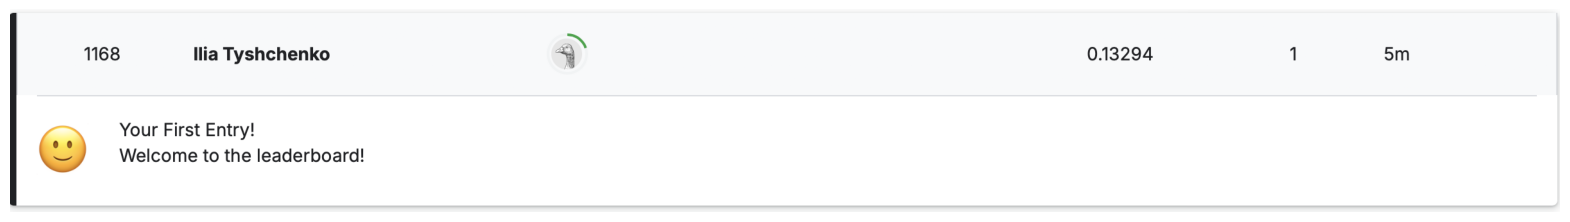

In [75]:
import matplotlib.image as mpimg
img = mpimg.imread('screenshot.png')
plt.figure(figsize=(20,6))
plt.imshow(img)
plt.axis('off')